In [75]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [76]:
df_seq_pathHFiltNorm = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt'
df_seq_HFiltNorm = pd.read_csv(df_seq_pathHFiltNorm, delimiter=' ')
df_metaH_path = '../ai_lab/SmartSeq/HCC1806_SmartS_MetaData.tsv'
df_metaH = pd.read_csv(df_metaH_path, delimiter='\t')
df_seq_HFiltNorm = df_seq_HFiltNorm.T
data_scaled = pd.DataFrame(StandardScaler().fit_transform(df_seq_HFiltNorm), columns=df_seq_HFiltNorm.columns)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)
str_labels = [str(label) for label in cluster_labels]
# Add cluster labels to the DataFrame
df_seq_HFiltNorm['cluster'] = cluster_labels
# centroids = kmeans.cluster_centers_

# Perform PCA to reduce the data to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_scaled)

# Create DataFrame for clustered data
df_clustered = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'Cluster': str_labels
})

# Plot 
fig = px.scatter_3d(df_clustered, x='PC1', y='PC2', z='PC3', color='Cluster',
                     symbol='Cluster', opacity=0.7, size_max=10,
                     title='KMeans Clustering in 3D with PCA')

fig.show()

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [77]:
df_seq_HFiltNorm['cluster']

output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam     0
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam      0
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam        0
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam        0
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam      0
                                                                       ..
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      0
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     0
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     0
Name: cluster, Length: 182, dtype: int32

In [78]:
def add_target_column(data, metadata_path, target_column_name, target_category):
    df_meta = pd.read_csv(metadata_path, delimiter='\t')
    df_meta.set_index('Filename', inplace=True)
    merged_transition = pd.merge(data, df_meta[target_column_name], left_index=True, right_index=True)
    dummy_variables = pd.get_dummies(merged_transition[target_column_name], prefix='category').astype('int')
    
    # Set the target category to 1 and the others to 0
    dummy_variables['Target'] = dummy_variables[target_category]
    dummy_variables.drop(columns=[col for col in dummy_variables.columns if col != 'Target'], inplace=True)
    
    merged_data = pd.concat([merged_transition, dummy_variables], axis=1)
    merged_data.drop(columns=[target_column_name], inplace=True)
    return merged_data

In [79]:
df_seq_HFiltNorm = add_target_column(df_seq_HFiltNorm, df_metaH_path, 'Condition', 'category_Normo')

In [80]:
# Take the two columns as np arrays
target = df_seq_HFiltNorm['Target']
cluster = df_seq_HFiltNorm['cluster']
# Count the number of correct predictions
correct = 0
for i in range(len(target)):
    if target[i] == cluster[i]:
        correct += 1
# Calculate the accuracy
print('Accuracy:', round(correct / len(target) * 100), '%')

Accuracy: 51 %


/var/folders/l4/fwn11xh17pb5ryvd5h_w9p8r0000gn/T/ipykernel_12933/2769255148.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



this is not a great result, as we should have expected. In fact if we look at the previous visulization we can see that instead of having equal number of elements in each cluster (as it should be since we know that the number of cells is more or less the same for each cathegory), we have a lot of elements in the first cluster and very few in the other.

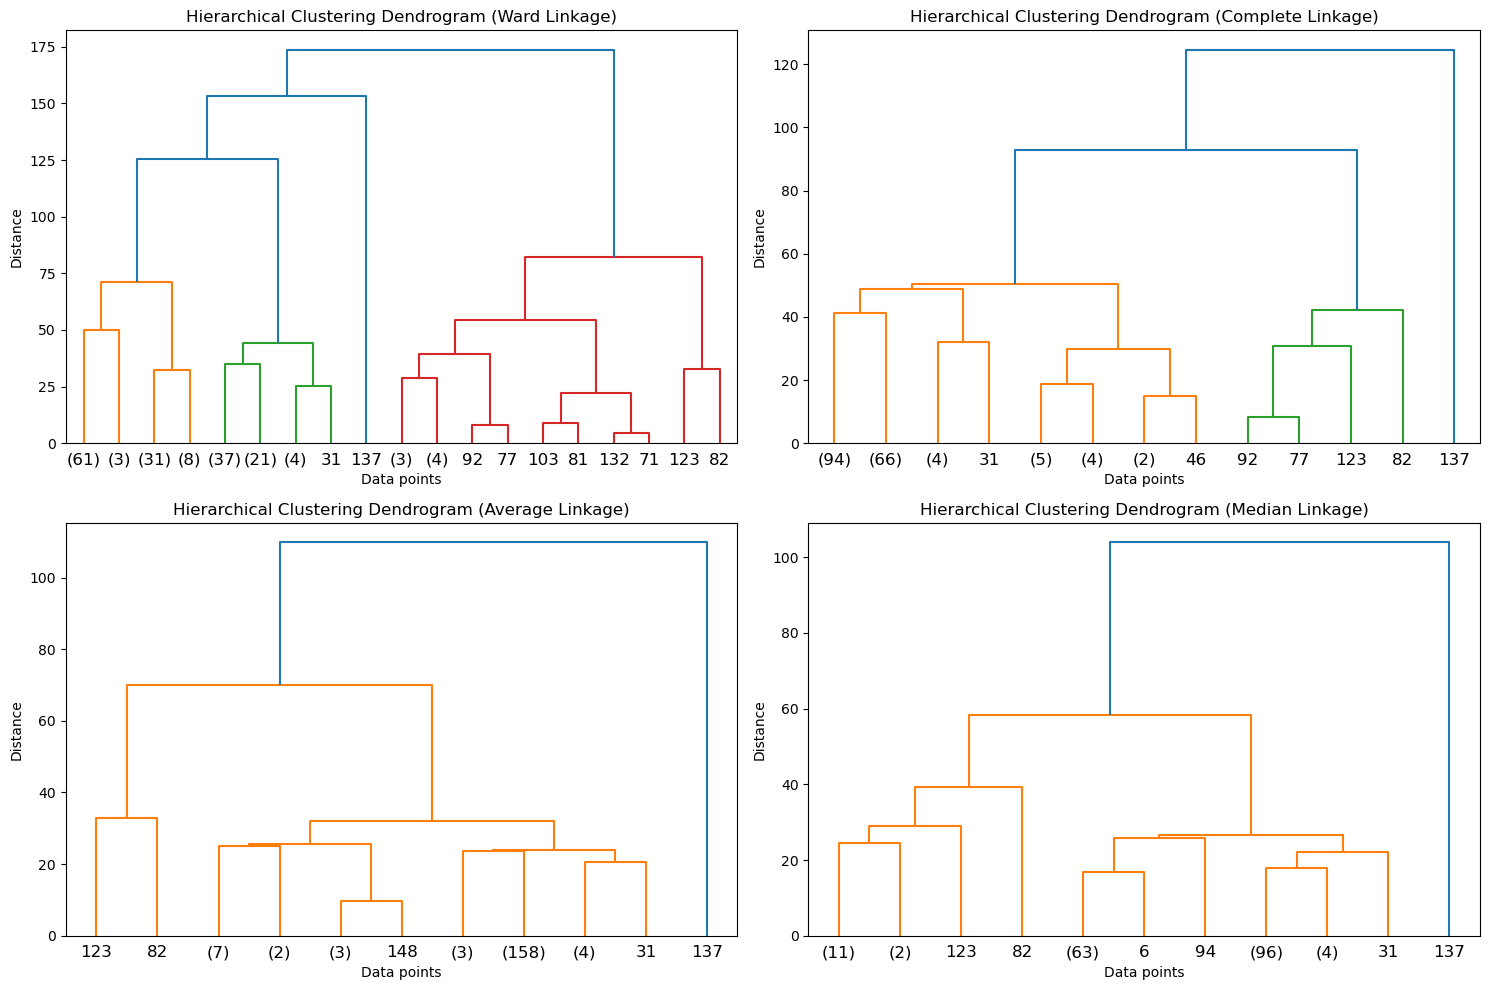

In [81]:
# Define linkage methods
methods = ['ward', 'complete', 'average', 'median']

# Plot dendrograms for each linkage method
plt.figure(figsize=(15, 10))
for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    linked = linkage(pca_result, method=method) # Here Euclidean distance is used. Does it make sense?
    dendrogram(linked, distance_sort='descending', truncate_mode='level', p=4)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Data points')
    plt.ylabel('Distance')

  
plt.tight_layout()
plt.show()


we clearly see that the ward method is the most effficent since it gives use 3 main clusters and a forth one, which probably contains outliers.
we then proceed plotting the clusters we found thanks to this method.

In [82]:
# Perform hierarchical clustering
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
model.fit(data_scaled)
model_labels = [str(label) for label in model.labels_]


# Calculate cluster means
cluster_means = []
for i in range(model.n_clusters_):
    cluster_means.append(df_seq_HFiltNorm[model.labels_ == i].mean())

# Perform PCA
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

# Create DataFrame for clustered data
df_clustered = pd.DataFrame({
    'PC1': pca_data[:, 0],
    'PC2': pca_data[:, 1],
    'PC3': pca_data[:, 2],
    'Cluster': model_labels
})

# Plot with Plotly Express
fig = px.scatter_3d(df_clustered, x='PC1', y='PC2', z='PC3', color='Cluster',
                    opacity=0.7, size_max=10,
                    title='PCA of clustered data')

# # Add annotations for legend
# for i, mean in enumerate(cluster_means):
#     fig.add_annotation(x=mean[0], y=mean[1], z=mean[2],
#                        text=f'Cluster {i+1}',
#                        showarrow=False,
#                        font=dict(color=sns.color_palette("Set1", n_colors=4)[i]))

fig.show()


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

